# Baseline analysis for predicting next day's Covid-19 cases from prior 30

In [117]:
import os
import importlib

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import dsci592.model as model

In [144]:
importlib.reload(model)

<module 'dsci592.model' from '/home/noah/projects/drexel/dsci592/DS-capstone-pt1/code/src/dsci592/model.py'>

In [3]:
pd.set_option("display.max_columns", None)
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [7]:
golden_dataset_file_name = os.path.join('/', 'data', 'projects', 'drexel', 'dsci592', 'feeFiFoFum.pkl')
with tf.device('/gpu:1'):  # using other GPU for another task
    df = model.load_dataset(golden_dataset_file_name)

# train_ds, val_ds, test_ds = model.get_train_test_eval_ds()


In [8]:
def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds()
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)
    

## Baseline 1: Guess zero every time

In [20]:
for name, ds in get_new_loop():
    sum = count = 0
    for _, y in ds:
        y_ = y.numpy().flatten()
        sum += y_.sum()
        count += y_.shape[0]
    print(f'{name}: {sum/count}')


train: 1738.2500355774011
validate: 1754.9772079984493
test: 1739.3318410911274


## Baseline 2: Guess the 30th date every time

In [51]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,-1:,:1].flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 9.785121290955985
validate: 9.549475865976769
test: 9.840210704599464


## Baseline 3: Guess the mean of the 30 days every time

In [63]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        x_ = np.mean(x_, axis=1).flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 121.31485035080716
validate: 120.17304839525893
test: 120.88257879796626


## Baseline 4: Linear regression

In [116]:
for name, ds in get_new_loop():
    errors = count = 0
    lr = LinearRegression()
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_date = np.array([days + 1]).reshape(-1,1)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            errors += np.abs(y[i] - lr.predict(next_date)[0][0])
            count += 1
    print(f'{name}: {errors[0][0]/count}')


train: [[36.93661786]]
validate: [[36.07154467]]
test: [[36.6260068]]


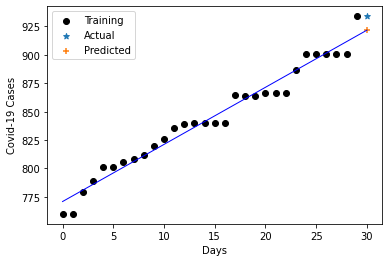

In [142]:
z = np.arange(days).reshape(-1,1)
plt.scatter(z, x_[i], color="black", label='Training')
z_ = np.arange(days+1).reshape(-1,1)
plt.plot(z_, lr.predict(z_), color="blue", linewidth=1)
plt.scatter(30, y_[i], marker='*', label='Actual')
plt.scatter(30, lr.predict(z_)[-1], marker='+', label='Predicted')
plt.ylabel('Covid-19 Cases')
plt.xlabel('Days')
plt.legend()
# plt.xticks(())
# plt.yticks(())
plt.savefig('linear_regression_example.png')
_ = plt.show()


# Baseline analysis for predicting next seven day's Covid-19 cases from prior 30

In [230]:
# train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=7)

DAYS_TO_PREDICT=3

def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=DAYS_TO_PREDICT)
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)

## Baseline 1: Guess zero every time

In [190]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for _, y in ds:
        count += y_.shape[0]
        y_ = y.numpy().squeeze()
        x_  = np.ones(y_.shape)
        errors += np.sum(np.abs(y_ - x_), axis=0)
    for i in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {i}: {errors[i]/count}')

train mae for day 0: 1756.0914379124538
validate mae for day 0: 1802.5589782118707
test mae for day 0: 1719.388321305421


In [188]:
# OLD VERSION -- SLOW!!!!
for name, ds in get_new_loop():
    sums = [0] * DAYS_TO_PREDICT
    counts = [0] * DAYS_TO_PREDICT
    for _, ys in ds:
        for y_days in ys:
            for i, y in enumerate(y_days):
                sums[i] += y
                counts[i] += 1
    for i in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {i}: {sums[i]/counts[i]}')


train mae for day 0: [1756.4777]
validate mae for day 0: [1798.8082]
test mae for day 0: [1720.9961]


## Baseline 2: Guess the 30th date every time

In [231]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        count += x_.shape[0]
        y_ = y.numpy().squeeze(-1)
        # print(y_.shape)
        # print(y_[:5])
        # print()
        x_ = x.numpy()[:,-1:,:1]
        x_ = x_.reshape(-1,1)
        # print(x_[:5])
        # print()
        x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
        # print(x_[:5])
        # print(x_.shape)
        errors += np.sum(np.abs(y_ - x_), axis=0)
    for i in range(DAYS_TO_PREDICT):
        print(f'{name} mae for day {i}: {errors[i]/count}')


(995, 3)
[[1873. 1873. 1972.]
 [1189. 1195. 1204.]
 [1848. 1848. 1873.]
 [2645. 2645. 2645.]
 [2599. 2599. 2599.]]

[[1873.]
 [1183.]
 [1759.]
 [2632.]
 [2599.]]

[[1873. 1873. 1873.]
 [1183. 1183. 1183.]
 [1759. 1759. 1759.]
 [2632. 2632. 2632.]
 [2599. 2599. 2599.]]
(995, 3)


NameError: name 'abort' is not defined

In [ ]:
(995, 1)
[[1972.]
 [1204.]
 [1873.]
 [2645.]
 [2599.]]

[[1873.]
 [1195.]
 [1848.]
 [2645.]
 [2599.]]

[[1873.]
 [1195.]
 [1848.]
 [2645.]
 [2599.]]
(995, 1)


(995, 2)
[[1873. 1972.]
 [1195. 1204.]
 [1848. 1873.]
 [2645. 2645.]
 [2599. 2599.]]

[[1873.]
 [1189.]
 [1848.]
 [2645.]
 [2599.]]

[[1873. 1873.]
 [1189. 1189.]
 [1848. 1848.]
 [2645. 2645.]
 [2599. 2599.]]
(995, 2)

(995, 3)
[[1873. 1873. 1972.]
 [1189. 1195. 1204.]
 [1848. 1848. 1873.]
 [2645. 2645. 2645.]
 [2599. 2599. 2599.]]

[[1873.]
 [1183.]
 [1759.]
 [2632.]
 [2599.]]

[[1873. 1873. 1873.]
 [1183. 1183. 1183.]
 [1759. 1759. 1759.]
 [2632. 2632. 2632.]
 [2599. 2599. 2599.]]
(995, 3)

In [185]:
train mae for day 0: 9.840150955581118
validate mae for day 0: 9.792210488958693
test mae for day 0: 9.854986715908877

array([1759., 1759., 1759., 1759., 1759., 1759., 1759.], dtype=float32)

In [184]:
y_[0]

array([1759., 1848., 1848., 1873., 1873., 1873., 1972.], dtype=float32)

In [179]:
x_

array([[1759., 1759., 1759., ..., 1759., 1759., 1759.],
       [1131., 1131., 1131., ..., 1131., 1131., 1131.],
       [1733., 1733., 1733., ..., 1733., 1733., 1733.],
       ...,
       [ 961.,  961.,  961., ...,  961.,  961.,  961.],
       [ 515.,  515.,  515., ...,  515.,  515.,  515.],
       [1282., 1282., 1282., ..., 1282., 1282., 1282.]], dtype=float32)

In [112]:
x = x_[0]
z = np.arange(x.shape[0]).reshape(-1,1)
y = y_[0]
# z = np.expand_dims(z,1)
lr = LinearRegression()
lr.fit(z,x)
np.abs(y - lr.predict(np.array([31]).reshape(-1,1))[0][0])

6.5670003707823525

In [104]:
z

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29]])

In [91]:
z = np.arange(x.shape[0])
z = np.expand_dims(z,1)
print(z.shape)
x = np.concatenate((z, x), axis=1)

(30, 1)


array([[  0., 488.],
       [  1., 491.],
       [  2., 492.],
       [  3., 498.],
       [  4., 500.],
       [  5., 515.],
       [  6., 530.],
       [  7., 530.],
       [  8., 531.],
       [  9., 532.],
       [ 10., 538.],
       [ 11., 548.],
       [ 12., 553.],
       [ 13., 569.],
       [ 14., 578.],
       [ 15., 579.],
       [ 16., 579.],
       [ 17., 582.],
       [ 18., 591.],
       [ 19., 595.],
       [ 20., 606.],
       [ 21., 633.],
       [ 22., 638.],
       [ 23., 640.],
       [ 24., 651.],
       [ 25., 662.],
       [ 26., 672.],
       [ 27., 687.],
       [ 28., 687.],
       [ 29., 692.]])

In [95]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)

reg.coef_

reg.intercept_

reg.predict(np.array([[3, 5]]))

array([16.])

In [97]:
y.shape

(4,)